In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../")
DATA_PATH = '../data/'
data = pd.read_pickle(DATA_PATH + 'train_data.pkl')

## Data

In [2]:
# sample size
k = 1
data = data.sample(frac=k, random_state=137)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from data_pipeline import data_pipeline as data_pipeline
from data_pipeline import dropFalseMCParticles

pipeline = data_pipeline()

unused_features = [
    'index',
    'has_MCParticle_not_electron',
    'is_downstream_reconstructible_not_electron',
    'is_true_seed',
    'seed_mva_value',
    'seed_nbIT',
    'seed_nLayers'
]

data = data.drop(unused_features, axis=1)
data = dropFalseMCParticles().fit_transform(data)
data = data.astype(np.float32)
data['is_downstream_reconstructible'] = data['is_downstream_reconstructible'].astype(np.int64)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1754766 entries, 1042314 to 3481
Data columns (total 9 columns):
is_downstream_reconstructible    int64
seed_chi2PerDoF                  float32
seed_p                           float32
seed_pt                          float32
seed_nLHCbIDs                    float32
seed_x                           float32
seed_y                           float32
seed_tx                          float32
seed_ty                          float32
dtypes: float32(8), int64(1)
memory usage: 80.3 MB


In [5]:
# split on train and test
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

x_train = train_set.drop(['is_downstream_reconstructible'], axis=1)
x_train = pipeline.fit_transform(x_train)
y_train = train_set['is_downstream_reconstructible'].copy()

x_test = test_set.drop(['is_downstream_reconstructible'], axis=1)
x_test = pipeline.transform(x_test)
y_test = test_set['is_downstream_reconstructible'].copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f186a2cb470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f18586d5128>]], dtype=object)

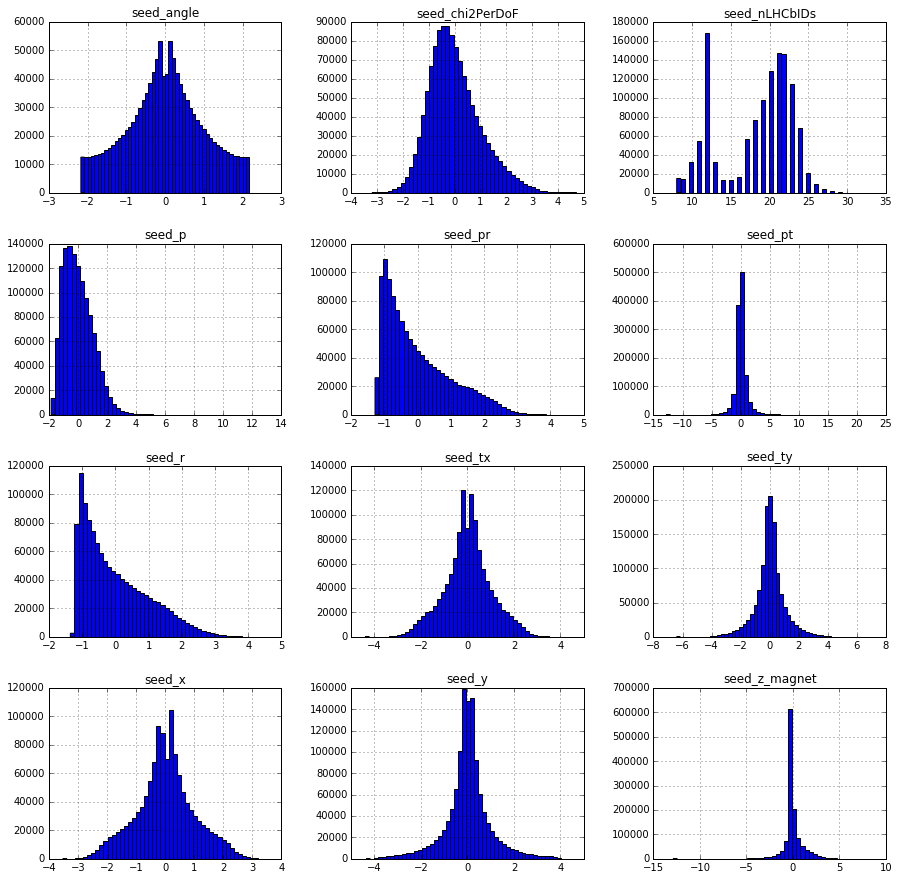

In [6]:
x_train.hist(bins=50, figsize=(15,15))

In [7]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1228336 entries, 385628 to 103571
Data columns (total 12 columns):
seed_chi2PerDoF    1228336 non-null float32
seed_p             1228336 non-null float32
seed_pt            1228336 non-null float32
seed_nLHCbIDs      1228336 non-null float32
seed_x             1228336 non-null float32
seed_y             1228336 non-null float32
seed_tx            1228336 non-null float32
seed_ty            1228336 non-null float32
seed_angle         1228336 non-null float32
seed_pr            1228336 non-null float32
seed_z_magnet      1228336 non-null float64
seed_r             1228336 non-null float32
dtypes: float32(11), float64(1)
memory usage: 70.3 MB


## Model

In [8]:
from models import KerasDNN

Using TensorFlow backend.


### training

In [9]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [10]:
import keras.backend as K

K.clear_session()

DNNclf = KerasDNN(
    (x_train.shape[1],),
    (2,),
    neurons=100,
    layers=3,
    dropout=0.05,
    loss_metric='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    last_layer_act='softmax'
)

DNNclf.fit(
    x_train.values, y_train.values,
    epochs=8,
    validation_data=(x_test.values, y_test.values),
    class_weight=class_weight
)

Train on 1228336 samples, validate on 526430 samples
Epoch 1/8
1228336/1228336 [==============================] - 159s - loss: 0.4005 - acc: 0.8271 - val_loss: 0.3481 - val_acc: 0.8578
Epoch 2/8
1228336/1228336 [==============================] - 219s - loss: 0.3662 - acc: 0.8476 - val_loss: 0.3328 - val_acc: 0.8672
Epoch 3/8
1228336/1228336 [==============================] - 232s - loss: 0.3571 - acc: 0.8530 - val_loss: 0.3276 - val_acc: 0.8697
Epoch 4/8
1228336/1228336 [==============================] - 231s - loss: 0.3515 - acc: 0.8560 - val_loss: 0.3201 - val_acc: 0.8735
Epoch 5/8
1228336/1228336 [==============================] - 232s - loss: 0.3485 - acc: 0.8578 - val_loss: 0.3209 - val_acc: 0.8719
Epoch 6/8
1228336/1228336 [==============================] - 214s - loss: 0.3457 - acc: 0.8588 - val_loss: 0.3229 - val_acc: 0.8711
Epoch 7/8
1228336/1228336 [==============================] - 205s - loss: 0.3430 - acc: 0.8606 - val_loss: 0.3257 - val_acc: 0.8696
Epoch 8/8
1228336/12283

In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [12]:
accuracy_score(y_train.values, DNNclf.predict(x_train.values))

0.87290203983274939

In [13]:
accuracy_score(y_test.values, DNNclf.predict(x_test.values))

0.8736565165359117

In [14]:
roc_auc_score(y_train.values, DNNclf.predict_proba(x_train.values)[:,1])

0.92881400681132931

In [15]:
roc_auc_score(y_test.values, DNNclf.predict_proba(x_test.values)[:,1])

0.92884843269707618

In [16]:
for name, step in pipeline.named_steps.items():
    print(step)
    try:
        print(step.scaler.scale_)
        print('std: ', step.scaler.scale_)
        print('mean: ', step.scaler.mean_)
    except Exception as e:
            pass

addPR()
[ 0.17856324]
std:  [ 0.17856324]
mean:  [ 0.22914613]
ptScale()
[ 0.20677143]
std:  [ 0.20677143]
mean:  [ 3.08250979]
nLHCbIDsScale()
tyScale()
[ 0.06486862]
std:  [ 0.06486862]
mean:  [ 0.00013073]
pScale()
[ 0.44031953]
std:  [ 0.44031953]
mean:  [ 3.89077256]
addAngle()
[ 0.72259562]
std:  [ 0.72259562]
mean:  [ 0.00140145]
txScale()
[ 0.29576847]
std:  [ 0.29576847]
mean:  [-0.00422249]
chi2PerDoFScaler()
[ 0.37649142]
std:  [ 0.37649142]
mean:  [ 1.23350879]
addZ()
[ 0.04334942]
std:  [ 0.04334942]
mean:  [ 0.57604572]
xScale()
[ 718.45885408]
std:  [ 718.45885408]
mean:  [-3.58761813]
addR()
[ 519.91120035]
std:  [ 519.91120035]
mean:  [ 707.61042581]
yScale()
[ 504.799883]
std:  [ 504.799883]
mean:  [ 1.0987292]


In [17]:
DNNclf.model.save('../saved_models/keras_standard_model.h5')